### **Fine-tuning YOLO-NAS-POSE on the LARD Dataset**

First let's create the database thanks to https://github.com/jeffffffli/CrowdPose/tree/master

In [ ]:
import csv
import json
from pathlib import Path

# we get the csv, images and output paths
csv_root = Path("/home/aws_install/data/csv")
image_base = Path("/home/aws_install/data/yolonas_pose_base/images")
output_json = "/home/aws_install/data/yolonas_pose_base/annotations/yolonas_pose_annotations.json"

# our annotation in yolo nas pose COCO format
json_data = {
    "info": {}, # Add any relevant info here
    "categories": [{
        "id": 0, # Category ID for runway
        "name": "runway", # Category name
        "keypoints": ["A", "B", "C", "D"], # Keypoint names 4 corners
        "skeleton": [[0, 1], [1, 2], [2, 3], [3, 0]] # Skeleton connections between keypoints (a square)
    }],
    "images": [], # List of images
    "annotations": [] # List of annotations
}

annotation_id = 1
image_id = 1

# Collect all CSV files recursively
csv_files = list(csv_root.rglob("*.csv"))
print(f"🔍 {len(csv_files)} CSV found in {csv_root}")

# Parse all CSV rows into memory, index by image name (basename only)
csv_data_index = {}
for csv_file in csv_files:
    try:
        with open(csv_file, newline="") as f:
            reader = csv.DictReader(f, delimiter=";")
            for row in reader:
                img_name = Path(row["image"]).name
                csv_data_index[img_name] = row
    except Exception as e:
        print(f"⚠️ Trouble Reading {csv_file.name}: {e}")

# Process train and val folders
for split in ["train", "val"]:
    for image_path in (image_base / split).glob("*.jpeg"):
        img_name = image_path.name

        if img_name not in csv_data_index:
            print(f"❌ No annotation found : {img_name}")
            continue

        row = csv_data_index[img_name]

        try:
            width = int(row["width"]) # in pixels
            height = int(row["height"])
            # Extract keypoints A, B, C, D coordinates in absolute pixel so each (x,y) is within the real image dimensions
            xA, yA = float(row["x_A"]), float(row["y_A"])
            xB, yB = float(row["x_B"]), float(row["y_B"])
            xC, yC = float(row["x_C"]), float(row["y_C"])
            xD, yD = float(row["x_D"]), float(row["y_D"])
        except Exception as e:
            print(f"⚠️ Missing or invalid format for {img_name}: {e}")
            continue

        keypoints = [xA, yA, 2, xB, yB, 2, xC, yC, 2, xD, yD, 2] # Keypoints format: [x1, y1, v1, x2, y2, v2, ...] where v is visibility (2 = visible)
        x_coords = [xA, xB, xC, xD] # Collect x-coordinates of keypoints
        y_coords = [yA, yB, yC, yD] # Collect y-coordinates of keypoints
        # Calculate bounding box from keypoints
        # bbox format: [x,y, width, height] in absolute pixel coordinates
        x_min, y_min = min(x_coords), min(y_coords)
        x_max, y_max = max(x_coords), max(y_coords)
        bbox = [x_min, y_min, x_max - x_min, y_max - y_min]

        # add image to JSON
        json_data["images"].append({ 
            "id": image_id, # Unique image ID
            "file_name": str(image_path.relative_to(image_base)), # Relative path to the image
            "width": width, 
            "height": height
        })

        # add annotation
        json_data["annotations"].append({
            "id": annotation_id, # Unique annotation ID
            "image_id": image_id, # ID of the image this annotation belongs to
            "category_id": 0, # Category ID for runway
            "bbox": bbox, # Bounding box [x, y, width, height] 
            "keypoints": keypoints, # Keypoints in COCO format
            "num_keypoints": 4 # Number of keypoints (4 corners)
        })

        annotation_id += 1
        image_id += 1

# Save the JSON data to the output file
Path(output_json).parent.mkdir(parents=True, exist_ok=True)
with open(output_json, "w") as f:
    json.dump(json_data, f, indent=2)

print(f"✅ Export Finished : {output_json}")
print(f"🖼️ {len(json_data['images'])} images, 🧷 {len(json_data['annotations'])} annotations.")


🔍 13 CSV trouvés dans /home/aws_install/data/csv


✅ Export terminé : /home/aws_install/data/yolonas_pose_base/annotations/yolonas_pose_annotations.json
🖼️ 14432 images, 🧷 14432 annotations.


We build our dataset

In [1]:
import os
import json
import cv2
import numpy as np

from typing import List, Tuple, Union

from sklearn.model_selection import train_test_split

from super_gradients.common.decorators.factory_decorator import resolve_param
from super_gradients.common.factories.transforms_factory import TransformsFactory
from super_gradients.training.transforms.keypoint_transforms import AbstractKeypointTransform
from super_gradients.training.samples import PoseEstimationSample
from super_gradients.training.datasets.pose_estimation_datasets.abstract_pose_estimation_dataset import AbstractPoseEstimationDataset

from super_gradients.training.utils.distributed_training_utils import wait_for_the_master
from super_gradients.common.environment.ddp_utils import get_local_rank
from super_gradients.training.datasets.pose_estimation_datasets import YoloNASPoseCollateFN


class RunwayPoseEstimationDataset(AbstractPoseEstimationDataset):
    @classmethod
    def split_runway_pose_dataset(cls, annotation_file, train_annotation_file, val_annotation_file, val_fraction):
        """
        Splits the runway pose dataset into training and validation sets.
        :param annotation_file: Path to the original annotation file.
        :param train_annotation_file: Path to save the training annotations.
        :param val_annotation_file: Path to save the validation annotations.
        :param val_fraction: Fraction of the dataset to be used for validation.
        """
        with open(annotation_file, "r") as f:
            annotation = json.load(f)

        image_ids = [img["id"] for img in annotation["images"]]
        labels = [[ann["category_id"] for ann in annotation["annotations"] if ann["image_id"] == img_id] for img_id in image_ids]
        labels = [label[0] if len(label) else -1 for label in labels]

        train_ids, val_ids = train_test_split(image_ids, test_size=val_fraction, random_state=42, stratify=labels)

        train_annotations = {
            "info": annotation.get("info", {}),
            "categories": annotation["categories"],
            "images": [img for img in annotation["images"] if img["id"] in train_ids],
            "annotations": [ann for ann in annotation["annotations"] if ann["image_id"] in train_ids],
        }

        val_annotations = {
            "info": annotation.get("info", {}),
            "categories": annotation["categories"],
            "images": [img for img in annotation["images"] if img["id"] in val_ids],
            "annotations": [ann for ann in annotation["annotations"] if ann["image_id"] in val_ids],
        }

        with open(train_annotation_file, "w") as f:
            json.dump(train_annotations, f, indent=2)
        with open(val_annotation_file, "w") as f:
            json.dump(val_annotations, f, indent=2)

    @resolve_param("transforms", TransformsFactory())
    def __init__(
        self,
        data_dir: str,
        images_dir: str,
        json_file: str,
        transforms: List[AbstractKeypointTransform],
        edge_links: Union[List[Tuple[int, int]], np.ndarray],
        edge_colors: Union[List[Tuple[int, int, int]], np.ndarray, None],
        keypoint_colors: Union[List[Tuple[int, int, int]], np.ndarray, None],
    ):
        """
        :param data_dir: Root directory of the COCO dataset
        :param images_dir: path suffix to the images directory inside the data_dir
        :param json_file: path suffix to the json file inside the data_dir
        :param include_empty_samples: Not used, but exists for compatibility with COCO dataset config.
        :param target_generator: Target generator that will be used to generate the targets for the model.
            See DEKRTargetsGenerator for an example.
        :param transforms: Transforms to be applied to the image & keypoints
        """
        json_path = os.path.join(data_dir, json_file)
        with open(json_path, "r") as f:
            annotation = json.load(f)

        joints = annotation["categories"][0]["keypoints"]
        num_joints = len(joints)

        super().__init__( 
            transforms=transforms,
            num_joints=num_joints,
            edge_links=edge_links,
            edge_colors=edge_colors,
            keypoint_colors=keypoint_colors,
        )

        self.image_id_to_file = {img["id"]: os.path.join(data_dir, images_dir, img["file_name"]) for img in annotation["images"]}
        self.image_ids = list(self.image_id_to_file.keys())
        self.image_files = list(self.image_id_to_file.values())

        self.annotations = []
        for image_id in self.image_ids:
            anns = [ann for ann in annotation["annotations"] if ann["image_id"] == image_id]
            keypoints_list = []
            bboxes_list = []
            for ann in anns:
                kpts = np.array(ann["keypoints"]).reshape(num_joints, 3)
                x, y, w, h = ann["bbox"]
                keypoints_list.append(kpts)
                bboxes_list.append(np.array([x, y, w, h]))
            if keypoints_list:
                self.annotations.append((np.array(keypoints_list, dtype=np.float32), np.array(bboxes_list, dtype=np.float32)))
            else:
                self.annotations.append((np.zeros((0, num_joints, 3)), np.zeros((0, 4))))

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        :return: Number of samples in the dataset.
        """
        return len(self.image_ids)

    def load_sample(self, index) -> PoseEstimationSample:
        """
        Loads a sample from the dataset.
        :param index: Index of the sample to load.
        :return: PoseEstimationSample object containing the image, mask, joints, areas, bounding boxes, and is_crowd.
        """
        image = cv2.imread(self.image_files[index])
        joints, bboxes = self.annotations[index]
        areas = np.array([w * h for (_, _, w, h) in bboxes], dtype=np.float32)
        iscrowd = np.zeros(len(joints), dtype=bool)
        mask = np.ones(image.shape[:2], dtype=np.float32)
        return PoseEstimationSample(image=image, mask=mask, joints=joints, areas=areas, bboxes_xywh=bboxes, is_crowd=iscrowd, additional_samples=None)


[2025-06-27 15:54:23] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/aws_install/sg_logs/console.log
[WARNING]No module named 'pycocotools'


Let's split

In [2]:
RunwayPoseEstimationDataset.split_runway_pose_dataset(
    annotation_file="/home/aws_install/data/yolonas_pose_base/annotations/yolonas_pose_annotations.json",
    train_annotation_file="/home/aws_install/data/yolonas_pose_base/annotations/yolonas_pose_train.json",
    val_annotation_file="/home/aws_install/data/yolonas_pose_base/annotations/yolonas_pose_val.json",
    val_fraction=0.2
)

In [3]:
import json
import os

annotation_files = {
    "Complet": "/home/aws_install/data/yolonas_pose_base/annotations/yolonas_pose_annotations.json",
    "Train": "/home/aws_install/data/yolonas_pose_base/annotations/yolonas_pose_train.json",
    "Val": "/home/aws_install/data/yolonas_pose_base/annotations/yolonas_pose_val.json"
}

for label, path in annotation_files.items():
    if not os.path.exists(path):
        print(f"⚠️ Fichier manquant : {path}")
        continue

    print(f"\n📂 Vérification du fichier : {label}")
    with open(path, "r") as f:
        data = json.load(f)

    print(" - Nombre d'images :", len(data["images"]))
    print(" - Nombre d'annotations :", len(data["annotations"]))
    print(" - Nombre de catégories :", len(data["categories"]))

    keypoint_lengths = [len(ann["keypoints"]) for ann in data["annotations"]]
    if keypoint_lengths:
        print(" - Keypoints par annotation :")
        print(f"   > Min : {min(keypoint_lengths)}")
        print(f"   > Max : {max(keypoint_lengths)}")
        print(f"   > Moyenne : {sum(keypoint_lengths)/len(keypoint_lengths):.2f}")
    else:
        print(" - Pas de keypoints trouvés.")



📂 Vérification du fichier : Complet


 - Nombre d'images : 14432
 - Nombre d'annotations : 14432
 - Nombre de catégories : 1
 - Keypoints par annotation :
   > Min : 12
   > Max : 12
   > Moyenne : 12.00

📂 Vérification du fichier : Train
 - Nombre d'images : 11545
 - Nombre d'annotations : 11545
 - Nombre de catégories : 1
 - Keypoints par annotation :
   > Min : 12
   > Max : 12
   > Moyenne : 12.00

📂 Vérification du fichier : Val
 - Nombre d'images : 2887
 - Nombre d'annotations : 2887
 - Nombre de catégories : 1
 - Keypoints par annotation :
   > Min : 12
   > Max : 12
   > Moyenne : 12.00


In [ ]:
KEYPOINT_NAMES = [
    "corner_top_left",
    "corner_top_right",
    "corner_bottom_right",
    "corner_bottom_left",
]

FLIP_INDEXES = [
    1, 0, 3, 2
]

EDGE_LINKS = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
]

EDGE_COLORS = [[0, 255, 0]] * len(EDGE_LINKS)
KEYPOINT_COLORS = [[255, 0, 0]] * len(KEYPOINT_NAMES)
NUM_JOINTS = len(KEYPOINT_NAMES)
print(f"Number of joints: {NUM_JOINTS}")
# OKS_SIGMAS = [0.07] * NUM_JOINTS
# → Each joint has the same standard deviation (σ) of 0.07.
# → This defines how tolerant the OKS metric is to localization error for each joint.
# → When multiplied by 4, it's scaling sigma to pixel space (to align with image size).
# → OKS is like IoU, but for keypoints: it scores how close predicted joints are.
OKS_SIGMAS = [0.07] * NUM_JOINTS 

Number of joints: 4


In [5]:
from super_gradients.training.transforms.keypoints import (
    KeypointsRandomHorizontalFlip,
    KeypointsHSV,
    KeypointsBrightnessContrast,
    KeypointsRandomAffineTransform,
    KeypointsLongestMaxSize,
    KeypointsPadIfNeeded,
    KeypointsImageStandardize,
    KeypointsRemoveSmallObjects,
)

IMAGE_SIZE = 640

# Define the transforms for training and validation datasets
train_transforms = [
    KeypointsRandomHorizontalFlip(flip_index=FLIP_INDEXES, prob=0.5), # Random horizontal flip with specified keypoint flip indexes
    KeypointsHSV(prob=0.5, hgain=20, sgain=20, vgain=20), # Random HSV adjustments
    KeypointsBrightnessContrast(prob=0.5, brightness_range=[0.8, 1.2], contrast_range=[0.8, 1.2]), # Random brightness and contrast adjustments
    KeypointsRandomAffineTransform(
        max_rotation=15,  # Maximum rotation in degrees
        min_scale=0.8,  # Minimum scale factor
        max_scale=1.2, # Maximum scale factor
        max_translate=0.1, # Maximum translation as a fraction of the image size
        image_pad_value=127,    # Padding value for the image
        mask_pad_value=1, # Padding value for the mask
        prob=0.75, # Probability of applying the affine transformation
        interpolation_mode=[0, 1, 2, 3, 4], # Interpolation modes to choose from
    ),
    KeypointsLongestMaxSize(max_height=IMAGE_SIZE, max_width=IMAGE_SIZE), # Resize the image to the longest side with a maximum size
    KeypointsPadIfNeeded( 
        min_height=IMAGE_SIZE, # Minimum height after padding
        min_width=IMAGE_SIZE, # Minimum width after padding
        image_pad_value=[127, 127, 127], # Padding value for the image
        mask_pad_value=1, # Padding value for the mask
        padding_mode="bottom_right", # Padding mode to use
    ),
    KeypointsImageStandardize(max_value=255),
    KeypointsRemoveSmallObjects(min_instance_area=1, min_visible_keypoints=1),
]

val_transforms = [
    KeypointsLongestMaxSize(max_height=IMAGE_SIZE, max_width=IMAGE_SIZE),
    KeypointsPadIfNeeded(
        min_height=IMAGE_SIZE,
        min_width=IMAGE_SIZE,
        image_pad_value=[127, 127, 127],
        mask_pad_value=1,
        padding_mode="bottom_right",
    ),
    KeypointsImageStandardize(max_value=255),
]


In [6]:
train_dataset = RunwayPoseEstimationDataset(
    data_dir="/home/aws_install/data/yolonas_pose_base",     # Root directory of the dataset
    images_dir="/home/aws_install/data/yolonas_pose_base/images",
    json_file="/home/aws_install/data/yolonas_pose_base/annotations/yolonas_pose_train.json",
    transforms=train_transforms, 
    edge_links=EDGE_LINKS,
    edge_colors=EDGE_COLORS,
    keypoint_colors=KEYPOINT_COLORS,
)

val_dataset = RunwayPoseEstimationDataset(
    data_dir="/home/aws_install/data/yolonas_pose_base",     # Root directory of the dataset
    images_dir="/home/aws_install/data/yolonas_pose_base/images",
    json_file="/home/aws_install/data/yolonas_pose_base/annotations/yolonas_pose_val.json",
    transforms=val_transforms,
    edge_links=EDGE_LINKS,
    edge_colors=EDGE_COLORS,
    keypoint_colors=KEYPOINT_COLORS,
)


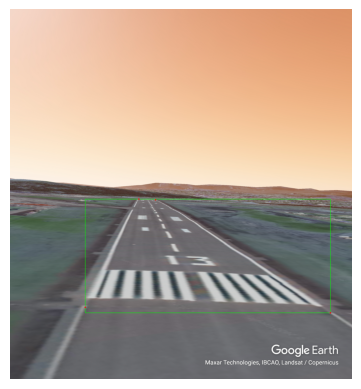

In [7]:
import matplotlib.pyplot as plt
sample = train_dataset.load_sample(599)  # charge le 1er sample

image = sample.image.copy()

for bbox in sample.bboxes_xywh:
    x, y, w, h = bbox.astype(int)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

for joints in sample.joints:
    for (x, y, v) in joints:
        if v > 0:
            cv2.circle(image, (int(x), int(y)), 5, (255, 0, 0), -1)

plt.imshow(image)
plt.axis('off')
plt.show()


In [8]:
from torch.utils.data import DataLoader

# Create dataloaders
train_dataloader_params = {"shuffle": True, "batch_size": 24, "drop_last": True, "pin_memory": False, "collate_fn": YoloNASPoseCollateFN()}

val_dataloader_params = {"shuffle": True, "batch_size": 24, "drop_last": True, "pin_memory": False, "collate_fn": YoloNASPoseCollateFN()}

train_dataloader = DataLoader(train_dataset, **train_dataloader_params)

val_dataloader = DataLoader(val_dataset, **val_dataloader_params)

In [9]:
from super_gradients.training import models
from super_gradients.common.object_names import Models
from super_gradients.training import Trainer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CHECKPOINT_DIR = "checkpoints"
trainer = Trainer(experiment_name="lard_ft_1", ckpt_root_dir=CHECKPOINT_DIR)

yolo_nas_pose = models.get(Models.YOLO_NAS_POSE_S, num_classes=4,arch_params={"num_keypoints": NUM_JOINTS}, pretrained_weights="coco_pose").to(device)

[2025-06-27 15:54:54] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco_pose dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2025-06-27 15:54:54] INFO - checkpoint_utils.py - License Notification: YOLO-NAS-POSE pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS-POSE.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2025-06-27 15:54:55] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_pose_s


In [10]:
from super_gradients.training.models.pose_estimation_models.yolo_nas_pose import YoloNASPosePostPredictionCallback
from super_gradients.training.utils.callbacks import ExtremeBatchPoseEstimationVisualizationCallback, Phase
from super_gradients.training.utils.early_stopping import EarlyStop
from super_gradients.training.metrics import PoseEstimationMetrics

post_prediction_callback = YoloNASPosePostPredictionCallback(
    pose_confidence_threshold=0.01,
    nms_iou_threshold=0.7,
    pre_nms_max_predictions=300,
    post_nms_max_predictions=30,
)

metrics = PoseEstimationMetrics(
    num_joints=NUM_JOINTS,
    oks_sigmas=OKS_SIGMAS,
    max_objects_per_image= 30,
    post_prediction_callback=post_prediction_callback,
    iou_thresholds_to_report=[0.5, 0.75]
)

visualization_callback = ExtremeBatchPoseEstimationVisualizationCallback(
    keypoint_colors=KEYPOINT_COLORS,
    edge_colors=EDGE_COLORS,
    edge_links=EDGE_LINKS,
    loss_to_monitor="YoloNASPoseLoss/loss",
    max=True,
    freq=1,
    max_images=16,
    enable_on_train_loader=True,
    enable_on_valid_loader=True,
    post_prediction_callback=post_prediction_callback,
)

early_stop = EarlyStop(
    phase=Phase.VALIDATION_EPOCH_END,
    monitor="AP",
    mode="max",
    min_delta=0.0001,
    patience=100,
    verbose=True,
)

train_params = {
    "warmup_mode": "LinearBatchLRWarmup",
    "warmup_initial_lr": 1e-8,
    "lr_warmup_epochs": 2,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.05,
    "max_epochs": 10,
    "zero_weight_decay_on_bias_and_bn": True,
    "batch_accumulate": 1,
    "average_best_models": True,
    "save_ckpt_epoch_list": [],
    "loss": "yolo_nas_pose_loss",
    "criterion_params": {
        "oks_sigmas": OKS_SIGMAS,
        "classification_loss_weight": 1.0,
        "classification_loss_type": "focal",
        "regression_iou_loss_type": "ciou",
        "iou_loss_weight": 2.5,
        "dfl_loss_weight": 0.01,
        "pose_cls_loss_weight": 1.0,
        "pose_reg_loss_weight": 34.0,
        "pose_classification_loss_type": "focal",
        "rescale_pose_loss_with_assigned_score": True,
        "assigner_multiply_by_pose_oks": True,
    },
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.000001},
    "ema": True,
    "ema_params": {"decay": 0.997, "decay_type": "threshold"},
    "mixed_precision": True, #technically autocast should be enabled but not the case here
    "sync_bn": False,
    "valid_metrics_list": [metrics],
    "phase_callbacks": [visualization_callback, early_stop],
    "pre_prediction_callback": None,
    "metric_to_watch": "AP",
    "greater_metric_to_watch_is_better": True,
}

More details here : https://vscode.dev/github/Deci-AI/super-gradients/blob/master/src/super_gradients/training/losses/yolo_nas_pose_loss.py#L307


In [ ]:
import torch

if torch.cuda.is_available():
    print(f"✅ GPU est disponible : {torch.cuda.get_device_name(0)}")
else:
    print("❌ Aucun GPU détecté. L'entraînement sera sur CPU.")

✅ GPU est disponible : NVIDIA A10G


In [ ]:
# Note, this is training for 10 epochs to demonstrate how to do it
trainer.train(model=yolo_nas_pose, training_params=train_params, train_loader=train_dataloader, valid_loader=val_dataloader)

[2025-06-27 15:55:05] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20250627_155505_269885`
[2025-06-27 15:55:05] INFO - sg_trainer.py - Checkpoints directory: checkpoints/lard_ft_1/RUN_20250627_155505_269885


The console stream is now moved to checkpoints/lard_ft_1/RUN_20250627_155505_269885/console_Jun27_15_55_05.txt


[2025-06-27 15:55:05] INFO - sg_trainer.py - Using EMA with params {'decay': 0.997, 'decay_type': 'threshold'}
[2025-06-27 15:55:16] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            11545      (len(train_set))
    - Batch size per GPU:           24         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             24         (num_gpus * batch_size)
    - Effective Batch size:         24         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         481        (len(train_loader))
    - Gradient updates per epoch:   481        (len(train_loader) / batch_accumulate)
    - Model: YoloNASPose_S  (22.21M parameters, 22.21M optimized)
    - Learning Rates and Weight Decays:
      - default: (22.21M parameters). LR: 0.0005 (22.21M parameters) WD: 0.0, (46.13

SUMMARY OF EPOCH 0
├── Train
│   ├── Yolonasposeloss/loss_cls = 699.8796
│   ├── Yolonasposeloss/loss_iou = 1.264
│   ├── Yolonasposeloss/loss_dfl = 0.0237
│   ├── Yolonasposeloss/loss_pose_cls = 0.9905
│   ├── Yolonasposeloss/loss_pose_reg = 23.7071
│   └── Yolonasposeloss/loss = 725.865
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.8629
    ├── Yolonasposeloss/loss_iou = 1.2012
    ├── Yolonasposeloss/loss_dfl = 0.0221
    ├── Yolonasposeloss/loss_pose_cls = 0.5914
    ├── Yolonasposeloss/loss_pose_reg = 23.7233
    ├── Yolonasposeloss/loss = 27.401
    ├── Ap = 0.0
    ├── Ar = 0.0001
    ├── Ap_0.50 = 0.0
    ├── Ap_0.75 = 0.0007
    ├── Ar_0.50 = 0.0
    └── Ar_0.75 = 0.0



Train epoch 1:  58%|█████▊    | 280/481 [49:45<35:12, 10.51s/it, YoloNASPoseLoss/loss=25.5, YoloNASPoseLoss/loss_cls=0.986, YoloNASPoseLoss/loss_dfl=0.022, YoloNASPoseLoss/loss_iou=1.14, YoloNASPoseLoss/loss_pose_cls=0.312, YoloNASPoseLoss/loss_pose_reg=23, gpu_mem=9.4]    

Evaluate 

In [ ]:
post_prediction_callback = YoloNASPosePostPredictionCallback(
    pose_confidence_threshold=0.01,
    nms_iou_threshold=0.7,
    pre_nms_max_predictions=300,
    post_nms_max_predictions=30,
)

metrics = PoseEstimationMetrics(
    num_joints=NUM_JOINTS,
    oks_sigmas=OKS_SIGMAS,
    max_objects_per_image=30,
    post_prediction_callback=post_prediction_callback,
)

trainer.test(model=best_model, test_loader=test_dataloader, test_metrics_list=metrics)

Test

In [ ]:
img_url = "content/images/2007_000783.jpg"
best_model.predict(img_url, conf=0.20, fuse_model=False).show()